# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

## Helper functions
Set of helper functions

In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [3]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) #we need to make sure approx 50% of images are in the same class

        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) #keep looping till the same class image is found
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [4]:
folder_dataset = dset.ImageFolder(root='./data/faces/training/')

In [5]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

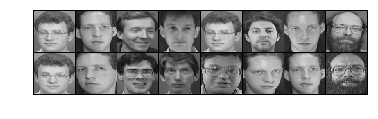

[[ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]]


In [19]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(5 - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [44]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=6,
                        batch_size=64)

In [45]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [46]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 1
 Current loss 10.571943283081055

Epoch number 2
 Current loss 5.793439865112305

Epoch number 3
 Current loss 4.252518177032471

Epoch number 4
 Current loss 8.662701606750488

Epoch number 5
 Current loss 10.182663917541504

Epoch number 6
 Current loss 11.15029525756836

Epoch number 7
 Current loss 4.719649314880371

Epoch number 8
 Current loss 4.095678806304932

Epoch number 9
 Current loss 6.548376083374023

Epoch number 10
 Current loss 5.225179672241211

Epoch number 11
 Current loss 4.401271343231201

Epoch number 12
 Current loss 3.3903579711914062

Epoch number 13
 Current loss 4.6985392570495605

Epoch number 14
 Current loss 5.053955078125

Epoch number 15
 Current loss 3.661916494369507

Epoch number 16
 Current loss 4.188446521759033

Epoch number 17
 Current loss 3.7222650051116943

Epoch number 18
 Current loss 4.498718738555908

Epoch number 19
 Current loss 3.3185181617736816

Epoch number 20
 Current loss 3.792555809020996

Epoch number 21
 Current l

Epoch number 165
 Current loss 0.29784050583839417

Epoch number 166
 Current loss 0.7572672367095947

Epoch number 167
 Current loss 0.7168194055557251

Epoch number 168
 Current loss 1.0250319242477417

Epoch number 169
 Current loss 0.7605761885643005

Epoch number 170
 Current loss 1.0690008401870728

Epoch number 171
 Current loss 1.2949135303497314

Epoch number 172
 Current loss 1.2818615436553955

Epoch number 173
 Current loss 1.0944416522979736

Epoch number 174
 Current loss 0.8151267170906067

Epoch number 175
 Current loss 1.2726956605911255

Epoch number 176
 Current loss 0.781699001789093

Epoch number 177
 Current loss 0.6138794422149658

Epoch number 178
 Current loss 0.8749383687973022

Epoch number 179
 Current loss 1.3600281476974487

Epoch number 180
 Current loss 1.5036624670028687

Epoch number 181
 Current loss 1.8622685670852661

Epoch number 182
 Current loss 0.8619144558906555

Epoch number 183
 Current loss 0.7324700951576233

Epoch number 184
 Current loss 

Epoch number 326
 Current loss 0.9973933100700378

Epoch number 327
 Current loss 0.7082640528678894

Epoch number 328
 Current loss 0.8954116702079773

Epoch number 329
 Current loss 0.3332585096359253

Epoch number 330
 Current loss 1.0225483179092407

Epoch number 331
 Current loss 1.1730923652648926

Epoch number 332
 Current loss 0.46509212255477905

Epoch number 333
 Current loss 1.5086151361465454

Epoch number 334
 Current loss 0.23908033967018127

Epoch number 335
 Current loss 0.547627329826355

Epoch number 336
 Current loss 0.43131035566329956

Epoch number 337
 Current loss 0.7554462552070618

Epoch number 338
 Current loss 0.351860910654068

Epoch number 339
 Current loss 0.23938578367233276

Epoch number 340
 Current loss 0.2509111762046814

Epoch number 341
 Current loss 0.9450810551643372

Epoch number 342
 Current loss 1.0929062366485596

Epoch number 343
 Current loss 0.5274088978767395

Epoch number 344
 Current loss 0.7376582622528076

Epoch number 345
 Current los

Epoch number 486
 Current loss 0.3072126507759094

Epoch number 487
 Current loss 0.389804482460022

Epoch number 488
 Current loss 2.3054146766662598

Epoch number 489
 Current loss 0.1456202119588852

Epoch number 490
 Current loss 0.39641043543815613

Epoch number 491
 Current loss 1.001752495765686

Epoch number 492
 Current loss 0.8208943009376526

Epoch number 493
 Current loss 1.0538471937179565

Epoch number 494
 Current loss 0.3631480932235718

Epoch number 495
 Current loss 0.5924957394599915

Epoch number 496
 Current loss 0.6690393686294556

Epoch number 497
 Current loss 0.27840787172317505

Epoch number 498
 Current loss 0.24333931505680084

Epoch number 499
 Current loss 0.3704339861869812



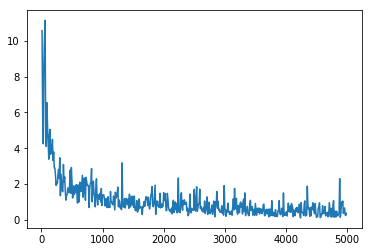

In [47]:
for epoch in range(1,500):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

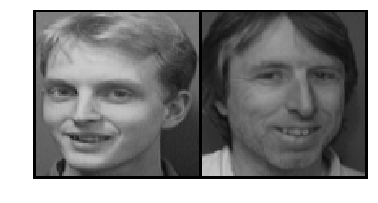

[[ 5.0610528]]


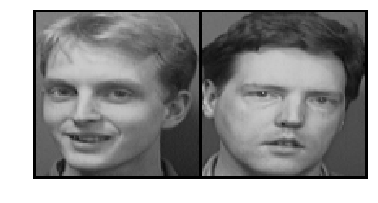

[[ 4.89391899]]


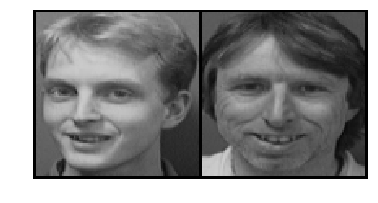

[[ 7.78810215]]


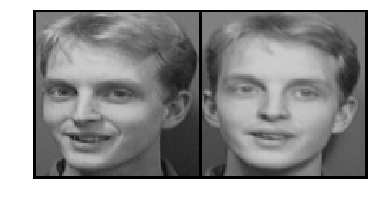

[[ 4.75363541]]


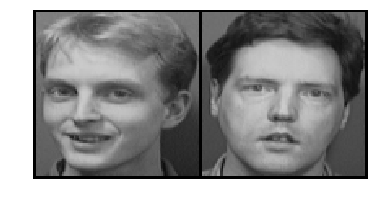

[[ 4.62155104]]


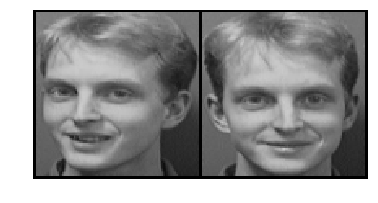

[[ 0.31757709]]


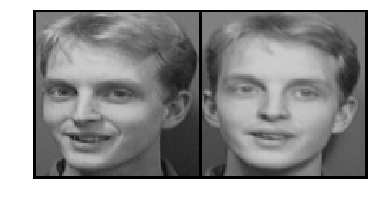

[[ 1.57075036]]


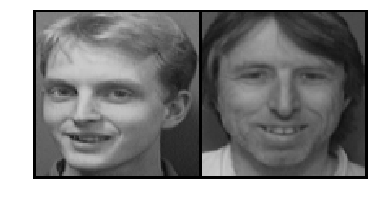

[[ 7.98069]]


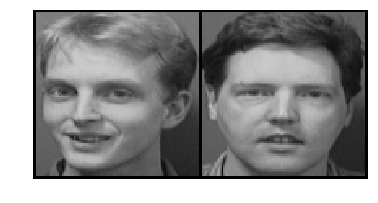

[[ 6.58347082]]


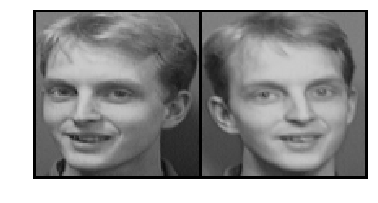

[[ 0.57146561]]


In [55]:
folder_dataset_test = dset.ImageFolder(root='./data/faces/testing/')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    imshow(torchvision.utils.make_grid(concatenated))
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    print (euclidean_distance.cpu().data.numpy())